In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import corner
#from astroquery.gaia import Gaia
import time
#from gaiaxpy import calibrate, convert
#from gaiaxpy import plot_spectra
import pandas as pd
from sklearn.neighbors import KDTree

In [62]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

In [63]:
#tab_gaia = Table.read('GaiaDR3_QsoCandidates2.fits.gz', format = 'fits')
tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
print('number of quasars:', len(tab_gaia))

number of quasars: 6649162


In [64]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_excess_noise','visibility_periods_used','ipd_frac_multi_peak','ruwe','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_rp_excess_factor','in_qso_candidates','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','host_galaxy_detected','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','host_galaxy_flag','source_selection_flags','allwise_oid','designation','w1mpro','w2mpro','

In [65]:
# -------------------------------------------------------------------------------
# construct purer sample
# -------------------------------------------------------------------------------

# Bailer-Jones+22
cuts_pure = np.where( (tab_gaia['gaia_crf_source']==True) |
                     ((tab_gaia['host_galaxy_flag']>0) & (tab_gaia['host_galaxy_flag']<6)) |
                     (tab_gaia['classlabel_dsc_joint']=='quasar') |
                     (tab_gaia['vari_best_class_name']=='AGN') )[0]

tab_gaia = tab_gaia[cuts_pure]
print('number of quasars:', len(tab_gaia))

number of quasars: 1942825


In [66]:
tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format='fits') 

In [67]:
c1 = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
c2 = SkyCoord(ra=tab_gaia['ra'], dec=tab_gaia['dec'], frame='icrs') 
x1 = c2.search_around_sky(c1, 1*u.arcsec) # Hogg thinks this is idiotic

In [68]:
max(x1[0]), max(x1[1])

(750413, 1928553)

In [69]:
tab = tab_gaia[x1[1]]
tab_sdss = tab_sdss[x1[0]]
len(tab), len(tab_sdss)

(400372, 400372)

In [70]:
bad = tab_sdss['Z'] < 0
tab_sdss[bad]['Z'] = np.nan

In [71]:
print(len(tab_gaia))
print(len(tab_gaia[~np.isnan(tab_gaia['j_m'])]))
#print(len(tab[~np.isnan(tab['j_m'])]))

1942825
113821


In [73]:
print(len(tab_gaia))
idx_wise = np.where(~np.isnan(tab_gaia['w1mpro']))[0]
idx_panstarrs = np.where(~np.isnan(tab_gaia['g_mean_psf_mag']))[0]
idx_tmass = np.where(~np.isnan(tab_gaia['j_m']))[0]
print(len(idx_wise))
print(len(idx_panstarrs))
print(len(idx_tmass))

1942825
1469898
1476974
113821


In [13]:
# plt.figure(figsize=(10,8))
# plt.scatter(tab_gaia['ra'][idx_wise], tab_gaia['dec'][idx_wise], 
#             color='red', s=0.01, alpha=0.1, label='WISE')
# plt.scatter(tab_gaia['ra'][idx_panstarrs], tab_gaia['dec'][idx_panstarrs], 
#             color='blue', s=0.01, alpha=0.1, label='Pan-STARRS')
# plt.scatter(tab_gaia['ra'][idx_tmass], tab_gaia['dec'][idx_tmass], 
#             color='green', s=0.1, alpha=0.1, label='2mass')
# plt.scatter(tab['ra'], tab['dec'], 
#             color='orange', s=0.1, alpha=0.1, label='SDSS')
# plt.xlabel('RA')
# plt.ylabel('dec')
# plt.legend()

In [14]:
# plt.figure(figsize=(10,8))
# plt.scatter(tab_gaia['ra'][idx_tmass], tab_gaia['dec'][idx_tmass], 
#             color='green', s=0.1, alpha=0.1, label='2mass')
# plt.xlabel('RA')
# plt.ylabel('dec')
# plt.legend()

## Get features

In [15]:
# gaia
g_bp = np.array(tab['phot_g_mean_mag']) - np.array(tab['phot_bp_mean_mag'])
g_rp = np.array(tab['phot_g_mean_mag']) - np.array(tab['phot_rp_mean_mag'])
bp_rp = np.array(tab['phot_bp_mean_mag']) - np.array(tab['phot_rp_mean_mag'])

# wise
w1w2 = np.array(tab['w1mpro']) - np.array(tab['w2mpro'])
g_w1 = np.array(tab['phot_g_mean_mag']) - np.array(tab['w2mpro']) # ERROR? SHOULD THIS BE w1 ?? 

# panstarrs
g_r = np.array(tab['g_mean_psf_mag'] - tab['r_mean_psf_mag'])
r_i = np.array(tab['r_mean_psf_mag'] - tab['i_mean_psf_mag'])
i_z = np.array(tab['i_mean_psf_mag'] - tab['z_mean_psf_mag'])
z_y = np.array(tab['z_mean_psf_mag'] - tab['y_mean_psf_mag'])

redshift = np.array(tab['redshift_qsoc'])
redshift_range = np.array(tab['redshift_qsoc_upper'] - tab['redshift_qsoc_lower'])

#2mass: g-j, h-w2, j-ks
#g_j = tab['phot_g_mean_mag'] - tab['j_m']
#h_w2 = tab['h_m'] - tab['w2mpro']
#j_ks = tab['j_m'] - tab['ks_m']


# stack
X = np.vstack([g_bp, g_rp, bp_rp, w1w2, g_w1, 
               g_r, r_i, i_z, z_y,
               # g_j, h_w2, j_ks,
               redshift, 
               #redshift_range
               ]).T
good = np.all(np.isfinite(X), axis=1)
print(X.shape)
X = X[good]
print(X.shape)

(400372, 10)
(306354, 10)


Text(0, 0.5, '$(z_\\mathrm{upper} - z_\\mathrm{lower})/(1+z)$')

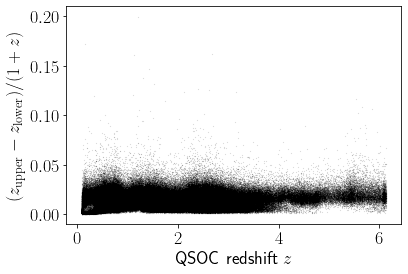

In [16]:
plt.scatter(redshift, redshift_range/(1+redshift), c='k', alpha=0.5, s=0.01)
plt.xlabel(r'QSOC redshift $z$')
plt.ylabel(r'$(z_\mathrm{upper} - z_\mathrm{lower})/(1+z)$')

Text(0, 0.5, 'Gaia redshift')

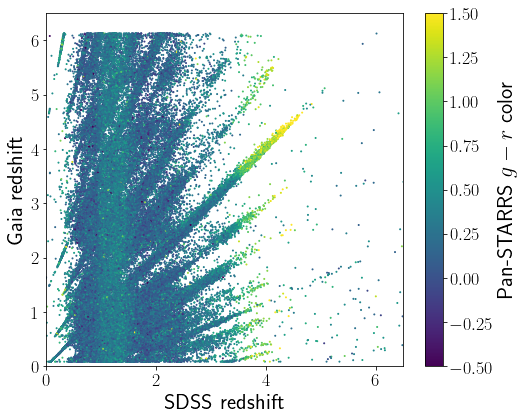

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(tab_sdss['Z'], redshift, s = 1, c=g_r, vmin=-0.5, vmax=1.5)
cbar = plt.colorbar(sc, label=r'Pan-STARRS $g-r$ color')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('Gaia redshift')

In [57]:
# fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
# sc = ax.scatter(tab_sdss['Z'], redshift-tab_sdss['Z'], s = 1, c=g_r, vmin=-0.5, vmax=1.5)
# cbar = plt.colorbar(sc, label=r'Pan-STARRS $g-r$ color')
# ax.set_xlim(0, 6.5)
# ax.set_ylim(-6.5, 6.5)
# plt.xlabel('SDSS redshift')
# plt.ylabel('Gaia redshift - SDSS redshift')

Text(0, 0.5, 'Gaia redshift')

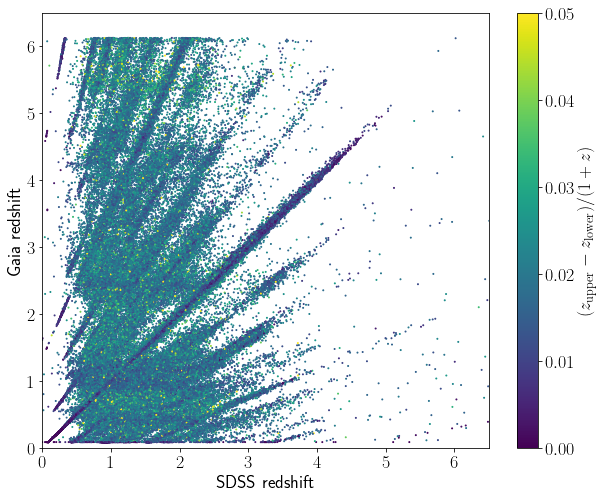

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
sc = ax.scatter(tab_sdss['Z'], redshift, s = 1, c = redshift_range/(1+redshift), vmin = 0, vmax = 0.05)
cbar = plt.colorbar(sc, label=r'$(z_\mathrm{upper} - z_\mathrm{lower})/(1+z)$')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('Gaia redshift')

## Build kd-tree

In [18]:
tree = KDTree(X)

In [19]:
k_vals = np.array([1, 5, 11, 15, 21, 25, 31])

In [20]:
dist_arr, ind_arr = tree.query(X, k=np.max(k_vals)+1)

In [21]:
# must exclude self match! (Hogg wants this note: won't generalize for test step)
# "Hits are sorted by distance (nearest first)." so remove first neighbor
dist2 = dist_arr[:, 1:]
ind2 = ind_arr[:, 1:]

In [22]:
med_z_arrs = []

for i, k in enumerate(k_vals):
    
    ind_k = ind2[:,:k]
    low_z, med_z, up_z = np.percentile(tab_sdss['Z'][good][ind_k], (2.5, 50, 97.5), axis = 1)
    med_z_arrs.append(med_z)

In [23]:
z_err_close = 0.2
frac_recovered_arr = np.empty(len(k_vals))

z_err_close2 = 0.1
frac_recovered_arr2 = np.empty(len(k_vals))

for i, k in enumerate(k_vals):
    frac_recovered_arr[i] = np.sum(np.abs(tab_sdss['Z'][good] - med_z_arrs[i]) < z_err_close) / len(med_z)
    frac_recovered_arr2[i] = np.sum(np.abs(tab_sdss['Z'][good] - med_z_arrs[i]) < z_err_close2) / len(med_z)

In [24]:
frac_recovered_baseline = np.sum(np.abs(tab_sdss['Z'][good] - tab['redshift_qsoc'][good]) < z_err_close) / len(tab['redshift_qsoc'][good])
frac_recovered_baseline2 = np.sum(np.abs(tab_sdss['Z'][good] - tab['redshift_qsoc'][good]) < z_err_close2) / len(tab['redshift_qsoc'][good])
print(frac_recovered_baseline)
print(frac_recovered_baseline2)

0.6721766322620236
0.6632359949600789


In [25]:
frac_recovered_arr

array([0.82554496, 0.85985494, 0.86292328, 0.86281557, 0.86129445,
       0.8604784 , 0.85927065])

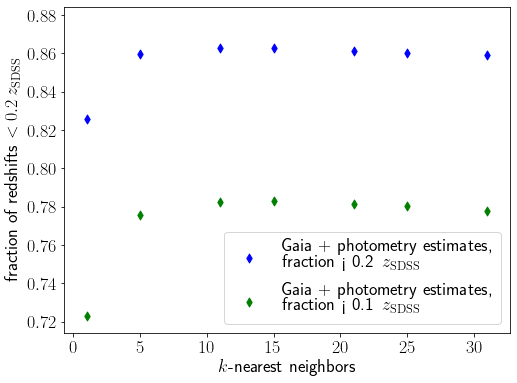

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(k_vals, frac_recovered_arr, s=40, marker='d', color='blue', 
            label=f'Gaia + photometry estimates,\n fraction < {z_err_close} $\,z_\mathrm{{SDSS}}$')
plt.scatter(k_vals, frac_recovered_arr2, s=40, marker='d', color='green',
            label=f'Gaia + photometry estimates,\n fraction < {z_err_close2} $\,z_\mathrm{{SDSS}}$')
#plt.axhline(frac_recovered_baseline, color='grey', label='Gaia QSOC redshifts')
plt.xlabel(r'$k$-nearest neighbors')
plt.ylabel(fr'fraction of redshifts $< {z_err_close}\,z_\mathrm{{SDSS}}$')
plt.legend()

In [27]:
#k_best = 11
#i_k_best = np.where(k_vals==k_best)[0]
i_k_best = np.argmax(frac_recovered_arr)
k_best = k_vals[i_k_best]
print(k_best)

11


Text(0, 0.5, 'redshift estimate (Gaia + photometry)')

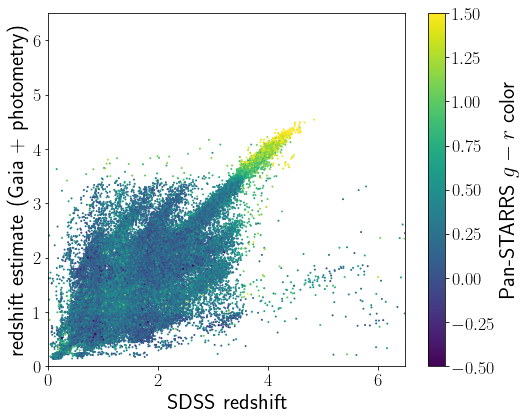

In [52]:
med_z = med_z_arrs[i_k_best]
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
sc = ax.scatter(tab_sdss['Z'][good], med_z, s = 1, c=g_r[good], vmin=-0.5, vmax=1.5)
cbar = plt.colorbar(sc, label=r'Pan-STARRS $g-r$ color')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('redshift estimate (Gaia + photometry)')

In [60]:
# med_z = med_z_arrs[i_k_best]
# fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
# sc = ax.scatter(tab_sdss['Z'][good], med_z - tab_sdss['Z'][good], s = 1, c=g_r[good], vmin=-0.5, vmax=1.5)
# cbar = plt.colorbar(sc, label=r'Pan-STARRS $g-r$ color')
# ax.set_xlim(0, 6.5)
# ax.set_ylim(-3, 3)
# plt.xlabel('SDSS redshift')
# plt.ylabel('redshift estimate (Gaia + photometry) - SDSS redshift')

Text(0, 0.5, 'redshift estimate (Gaia + photometry)')

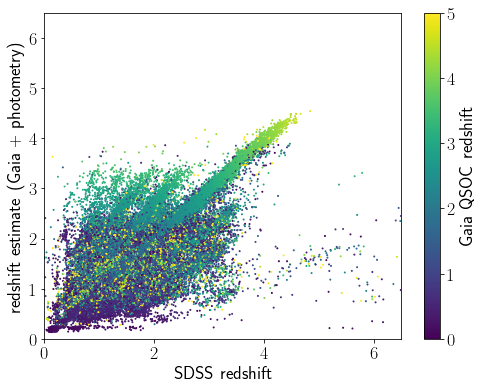

In [34]:
med_z = med_z_arrs[i_k_best]
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
sc = ax.scatter(tab_sdss['Z'][good], med_z, s = 1, c = redshift[good], vmin = 0, vmax = 5)
cbar = plt.colorbar(sc, label='Gaia QSOC redshift')
ax.set_xlim(0, 6.5)
ax.set_ylim(0, 6.5)
plt.xlabel('SDSS redshift')
plt.ylabel('redshift estimate (Gaia + photometry)')

## Test: Apply to all data

In [ ]:
# add: z - w1

In [ ]:
# gaia
g_bp_all = np.array(tab_gaia['phot_g_mean_mag']) - np.array(tab_gaia['phot_bp_mean_mag'])
g_rp_all = np.array(tab_gaia['phot_g_mean_mag']) - np.array(tab_gaia['phot_rp_mean_mag'])
bp_rp_all = np.array(tab_gaia['phot_bp_mean_mag']) - np.array(tab_gaia['phot_rp_mean_mag'])

# wise
w1w2_all = np.array(tab_gaia['w1mpro']) - np.array(tab_gaia['w2mpro'])
g_w1_all = np.array(tab_gaia['phot_g_mean_mag']) - np.array(tab_gaia['w2mpro'])

# panstarrs
g_r_all = np.array(tab_gaia['g_mean_psf_mag'] - tab_gaia['r_mean_psf_mag'])
r_i_all = np.array(tab_gaia['r_mean_psf_mag'] - tab_gaia['i_mean_psf_mag'])
i_z_all = np.array(tab_gaia['i_mean_psf_mag'] - tab_gaia['z_mean_psf_mag'])
z_y_all = np.array(tab_gaia['z_mean_psf_mag'] - tab_gaia['y_mean_psf_mag'])

redshift_all = np.array(tab_gaia['redshift_qsoc'])
#redshift_range_all = np.array(tab['redshift_qsoc_upper'] - tab['redshift_qsoc_lower'])

# stack
X_all = np.vstack([g_bp_all, g_rp_all, bp_rp_all, w1w2_all, g_w1_all, 
               g_r_all, r_i_all, i_z_all, z_y_all,
               redshift_all, 
               ]).T
good_all = np.all(np.isfinite(X_all), axis=1)
print(X_all.shape)
X_all = X_all[good_all]
print(X_all.shape)

In [ ]:
dist_all, ind_all = tree.query(X_all, k=k_best)

In [ ]:
low_z_all, med_z_all, up_z_all = np.percentile(tab_sdss['Z'][good][ind_all], (2.5, 50, 97.5), axis=1)

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(tab_gaia['redshift_qsoc'], bins=50, lw=2, label='Gaia redshift', histtype='step')
plt.hist(med_z_all, bins=50, lw=2, label='redshift estimate\n(Gaia + photometry)', histtype='step')
plt.xlabel(r'redshift $z$')
plt.ylabel('number in bin')
plt.legend()

In [ ]:
len(med_z_all)

In [ ]:
print(len(np.where(med_z_all > 4)[0]))
print(len(np.where(med_z_all > 4.5)[0]))
print(len(np.where(med_z_all > 5)[0]))

In [ ]:
# z_est = np.full(len(tab_gaia), np.nan)
# z_est[good_all] = med_z_all
# tab_gaia.add_column(z_est, name='redshift_photoz_est')

In [ ]:
len(tab_gaia)

In [ ]:
tab_photoz = tab_gaia[good_all]

In [ ]:
tab_photoz.add_column(med_z_all, name='redshift_photoz_est')

In [ ]:
len(tab_photoz)

In [ ]:
fn_new = '../data/gaia_photoz.fits'
tab_photoz.write(fn_new)

In [ ]:
tab_photoz_read = Table.read(fn_new, format='fits')
print(len(tab_photoz_read))